In [1]:
!pip install squarify

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS0_K273_ONLINE_DoThiPhuong/Topic_1/'

/content/gdrive/My Drive/LDS0_K273_ONLINE_DoThiPhuong/Topic_1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

In [5]:
df = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
string_to_date = lambda x : datetime.strptime(x, "%d-%m-%Y %H:%M").date()

#convert
df['InvoiceDate'] = df['InvoiceDate'].apply(string_to_date)
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [9]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,4.95,12680.0,France


In [ ]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df)
#profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Nhận xét:
- Số lượng Khách hàng và Đơn hàng ít trên tổng mẫu dữ liệu. Nhiều KH mua nhiều mặt hàng với số lượng lớn trong 1 đơn hàng => KH của DN chủ yếu là KH bán buôn

In [10]:
# loại bỏ DL trùng:
print('Trước khi drop, records = ', df.shape[0])
df.drop_duplicates(inplace = True)
print('Sau khi drop, records = ', df.shape[0])

Trước khi drop, records =  541909
Sau khi drop, records =  536640


In [11]:
# kiểm tra dữ liệu null:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [12]:
m = []
for c in ['Description', 'CustomerID']:
  m.append({
      'feature': c,
      'Missing_Value': df[df[c].isnull()].shape[0],
      'Percentage': df[df[c].isnull()].shape[0]/df.shape[0]*100
  })
df_null = pd.DataFrame(m)
df_null

,feature,Missing_Value,Percentage
0,Description,1454,0.270945
1,CustomerID,135037,25.163424


- Dữ liệu có nhiều giá trị null tại CustomerID và Description. Xử lý: Xóa bỏ null tại cột CustomerID do đây là bài toán phân cụm KH, CustomerID không được phép null; Cột Description không ảnh hưởng tới bài toán phân cụm nên xem xét loại bỏ

In [13]:
pd.options.display.float_format = '{:,.2f}'.format
df[['Quantity', 'UnitPrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,"536,640.00",9.62,219.13,"-80,995.00",1.00,3.00,10.00,"80,995.00"
UnitPrice,"536,640.00",4.63,97.23,"-11,062.06",1.25,2.08,4.13,"38,970.00"


- Dữ liệu có giá trị âm ở Quantity hoặc UnitPrice liên quan tới đơn hàng trả lại/hủy đơn đúng với thực tế nên vẫn giữ lại.
- Trung bình số lượng mỗi sản phẩm trong mỗi đơn hàng là 9,62; max là 80.995; range rộng
- Trung bình giá bán mỗi sản phẩm là 4,63; max là 38.970; range rộng

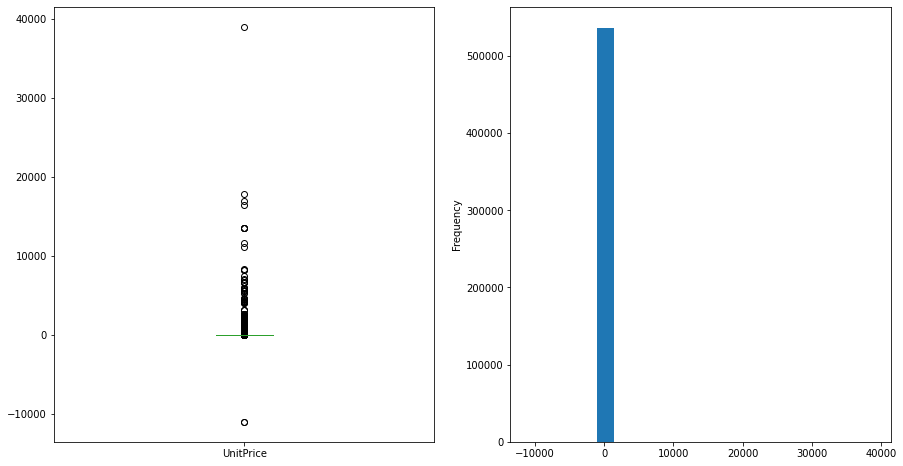

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
df.UnitPrice.plot(kind = 'box', ax = ax[0])
df.UnitPrice.plot(kind = 'hist', bins = 20, ax = ax[1])
plt.show()

Phần lớn sản phẩm có giá < 10.000

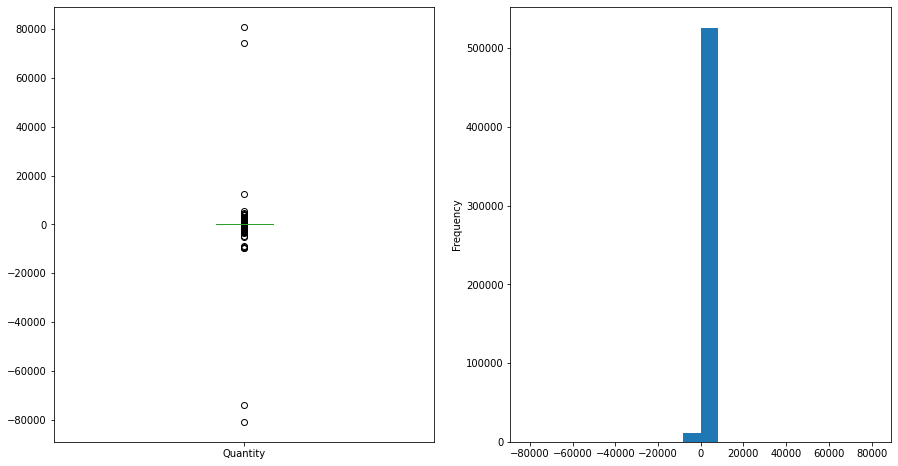

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
df.Quantity.plot(kind = 'box', ax = ax[0])
df.Quantity.plot(kind = 'hist', bins = 20, ax = ax[1])
plt.show()

Hầu hết Quantity có giá trị < 10.000

In [16]:
# sp theo StockCode
StockCode = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending = False)
StockCode

StockCode
22197      56427
84077      53751
85099B     47260
85123A     38811
84879      36122
           ...  
79323LP    -2618
79323W     -4838
72140F     -5368
23003      -8516
23005     -14468
Name: Quantity, Length: 4070, dtype: int64

- Sản phẩm có StockCode là 22197 được mua nhiều nhất (56.427 sản phẩm)
- Sản phẩm có StockCode là 23005 bị trả nhiều nhất (14.468 sản phẩm)

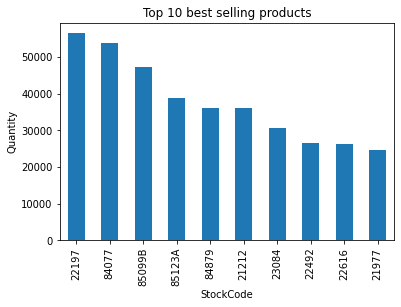

In [17]:
# top 10 sản phẩm bán chạy nhất
StockCode[0:10].plot(kind = 'bar')
plt.ylabel('Quantity')
plt.title('Top 10 best selling products')
plt.show()

- Top 3 sản phẩm bán chạy nhất là '22197', '84077' và '85099B' với tổng sản phẩm bán được là khoảng 47.000-56.000
- Các sản phẩm còn lại trong top 10 được bán trong khoảng 28.000-40.000 sản phẩm.

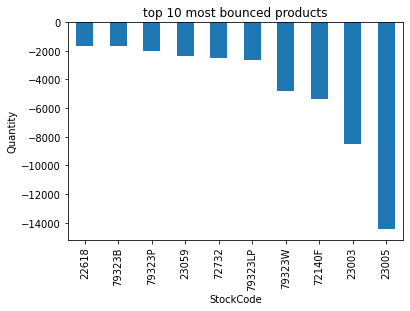

In [18]:
# top 10 sản phẩm bị trả hàng nhiều nhất
StockCode[-10:].plot(kind = 'bar')
plt.ylabel('Quantity')
plt.title('top 10 most bounced products')
plt.show()

- Sản phẩm bị trả hàng nhiều nhất là '23005' với khoảng 14.000 sp
- 6 sp bị trả hàng khoảng ~2.000 sp
- 3 sp còn lại trong top 10 bị trả hàng trong khoảng 5.000-8.000 sp

In [19]:
# sp theo Description
Description = df.groupby('Description')['Quantity'].sum().sort_values(ascending = False)
Description

Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS    53751
JUMBO BAG RED RETROSPOT              47260
POPCORN HOLDER                       36322
ASSORTED COLOUR BIRD ORNAMENT        36282
PACK OF 72 RETROSPOT CAKE CASES      36016
                                     ...  
Damaged                              -7540
Printing smudges/thrown away         -9058
check                               -12030
Unsaleable, destroyed.              -15644
printing smudges/thrown away        -19200
Name: Quantity, Length: 4223, dtype: int64

- Sản phẩm có Description là 'WORLD WAR 2 GLIDERS ASSTD DESIGNS' được mua nhiều nhất (53.751 sản phẩm)
- Sản phẩm có Description là 'printing smudges/thrown away' bị trả nhiều nhất (19.200 sản phẩm)
- Số liệu này không khớp với StockCode ở trên do:
  - Description bị null ở một số records
  - StockCode là duy nhất cho mỗi sản phẩm (hiểu là mã sản phẩm) trong khi Description có thể giống nhau với các sản phẩm có cùng đặc tính.

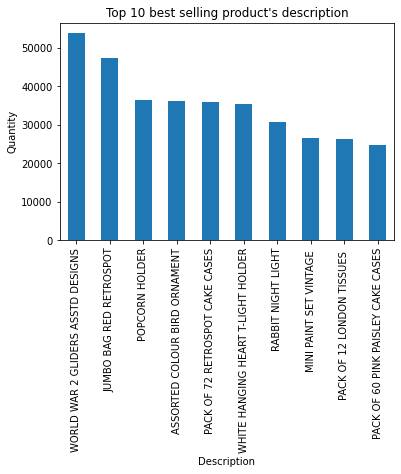

In [20]:
# top 10
Description[0:10].plot(kind = 'bar')
plt.ylabel('Quantity')
plt.title("Top 10 best selling product's description")
plt.show()

- Top 2 được bán từ 48.000-54.000 sp
- số còn lại trong top 10 được bán từ 28.000-37.000 sp

In [21]:
InvoiceNo_ = df.groupby('InvoiceNo')['StockCode'].count().sort_values(ascending = False)
InvoiceNo_

InvoiceNo
573585    1114
581219     749
581492     731
580729     721
558475     705
          ... 
540272       1
540279       1
557501       1
573926       1
538092       1
Name: StockCode, Length: 25900, dtype: int64

- Đơn hàng có mã 573585 mua nhiều mặt hàng nhất với 1.114 mặt hàng
- Một số đơn hàng chỉ mua 1 mặt hàng.

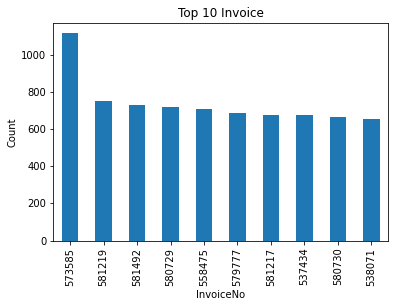

In [22]:
# top 10
InvoiceNo_[0:10].plot(kind = 'bar')
plt.ylabel('Count')
plt.title("Top 10 Invoice")
plt.show()

- Đơn hàng số 573585 mua nhiều mặt hàng nhất (1.114)
- Các đơn hàng khác trong top 10 mua khoảng 700-750 mặt hàng.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

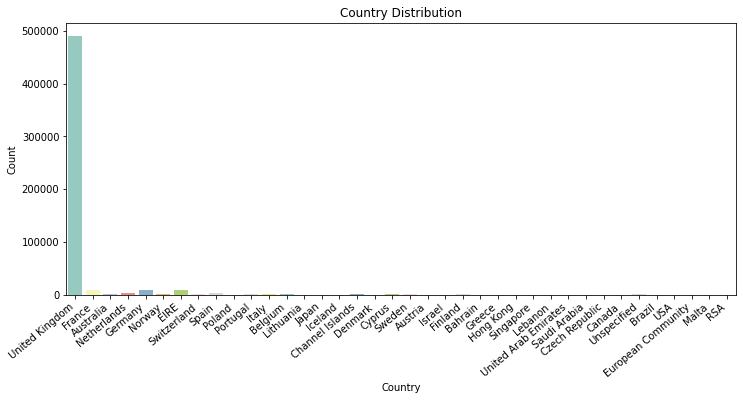

In [46]:
plt.figure(figsize=(12,5))
sns.countplot(df['Country'],palette= 'Set3')
plt.xticks(rotation=40,ha='right')
plt.title("Country Distribution")
plt.xlabel('Country')
plt.ylabel('Count')

KH chủ yếu đến từ United Kingdom (91,36%)

In [48]:
_UK = df[df['Country']=='United Kingdom'].shape[0]/df.shape[0]*100
_UK

91.36460196779964

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


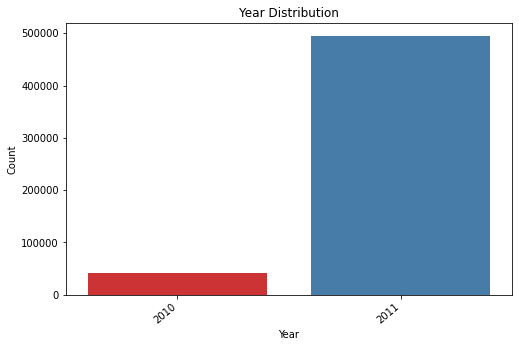

In [53]:
plt.figure(figsize=(8,5))
sns.countplot(df['InvoiceDate'].dt.year,palette= 'Set1')
plt.xticks(rotation=40,ha='right')
plt.title("Year Distribution")
plt.xlabel('Year')
plt.ylabel('Count');

Đơn hàng chủ yếu của năm 2011 (92.177%)

In [54]:
_2011 = df[df['InvoiceDate'].dt.year == 2011].shape[0]/df.shape[0]*100
_2011

92.17706469886703

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Month')

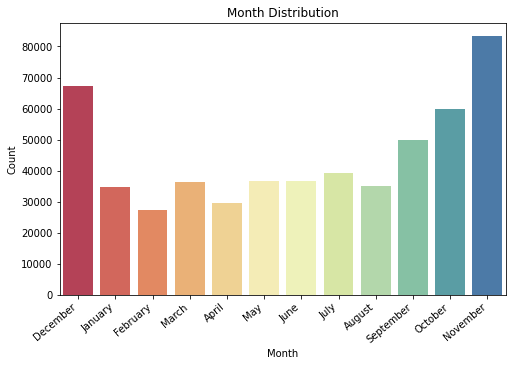

In [55]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=40,ha='right')
sns.countplot(df['InvoiceDate'].dt.month_name(),palette= 'Spectral')
plt.title("Month Distribution")
plt.ylabel('Count')
plt.xlabel('Month')

Những tháng cuối năm (9-12) bán nhiều hàng hơn đầu năm.

- Chỉ sử dụng các cột InvoiceNo, Quantity, UnitPrice, InvoiceDate và CustomerID để phân cụm KH.

In [56]:
df = df[['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice',	'CustomerID']]
df = df.dropna()

In [57]:
# Let’s take a closer look at the data we will need to manipulate.
print('Transactions timeframe from {} to {}'.format(df['InvoiceDate'].min(), df['InvoiceDate'].max()))
print('{:,} transactions don\'t have a customer id'.format(df[df.CustomerID.isnull()].shape[0]))
print('{:,} unique CustomerID'.format(len(df.CustomerID.unique())))

Transactions timeframe from 2010-12-01 00:00:00 to 2011-12-09 00:00:00
0 transactions don't have a customer id
4,372 unique CustomerID


In [58]:
df['total_sales'] = df['Quantity']*df['UnitPrice']

In [59]:
max_date = df['InvoiceDate'].max().date()

Recency = lambda x : (max_date - x.max().date()).days
Frequency = lambda x : len(x.unique())
Monetary = lambda x : round(sum(x), 2)

df_RFM = df.groupby('CustomerID').agg({'InvoiceDate': Recency,
                                        'InvoiceNo': Frequency,
                                        'total_sales': Monetary})

In [60]:
df_RFM.head()

,InvoiceDate,InvoiceNo,total_sales
CustomerID,,,
"12,346.00",325,2,0.00
"12,347.00",2,7,"4,310.00"
"12,348.00",75,4,"1,797.24"
"12,349.00",18,1,"1,757.55"
"12,350.00",310,1,334.40


In [ ]:
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending = False)

In [ ]:
df_RFM.head()

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,1,77,279489.02
18102.0,0,62,256438.49
17450.0,8,55,187322.17
14911.0,1,248,132458.73
12415.0,24,26,123725.45


In [ ]:
df_RFM.shape

(4372, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

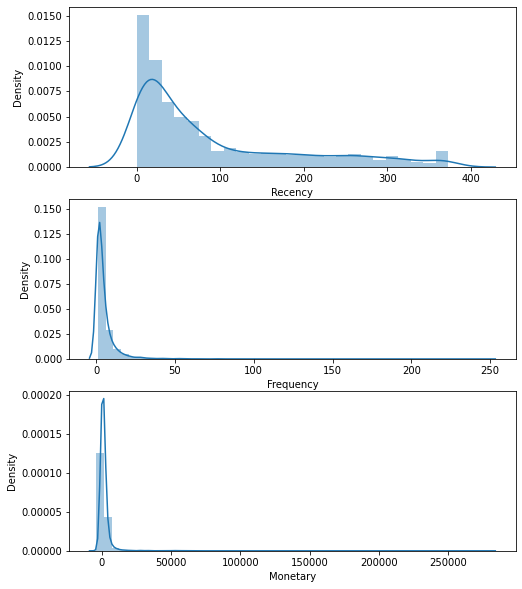

In [ ]:
### Virsulization
plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
sns.distplot(df_RFM['Recency'])# Plot distribution of R
plt.subplot(3, 1, 2)
sns.distplot(df_RFM['Frequency'])# Plot distribution of F
plt.subplot(3, 1, 3)
sns.distplot(df_RFM['Monetary']) # Plot distribution of M
plt.show()

## Nhận xét:
- Recency tập trung từ 0-100 ngày, 100-400 có tỷ lệ ít hơn
- Frequency tập trung từ 0-20 đơn hàng, từ 20-50 đơn tỷ lệ giảm dần và từ 50-250 đơn có nhưng rất ít
- Monetary tập trung từ 0-10000, từ 10000-280000 có nhưng rất ít
- Frequency, Monetary: phân phối lệch phải

In [ ]:
!pip install pyclustertend

In [ ]:
from pyclustertend import hopkins

In [ ]:
hopkins(df_RFM, len(df_RFM))

0.005816714465357942

### Chỉ số hopkins cho thấy dữ liệu có khả năng phân cụm lớn



## Calculate RFM quartiles

In [ ]:
r_labels = range(4, 0, -1) #ngày càng xa thì giá trị càng nhỏ
f_labels = range(1, 5)
m_labels = range(1, 5)

In [ ]:
[*r_labels]

[4, 3, 2, 1]

In [ ]:
r_groups = pd.qcut(df_RFM['Recency'].rank(method = 'first'), q = 4, labels = r_labels)
f_groups = pd.qcut(df_RFM['Frequency'].rank(method = 'first'), q = 4, labels = f_labels)
m_groups = pd.qcut(df_RFM['Monetary'].rank(method = 'first'), q = 4, labels = m_labels)

In [ ]:
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values )
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
14646.0,1,77,279489.02,4,4,4
18102.0,0,62,256438.49,4,4,4
17450.0,8,55,187322.17,4,4,4
14911.0,1,248,132458.73,4,4,4
12415.0,24,26,123725.45,3,4,4


## Concat RFM quartile values to create RFM Segments

In [ ]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)

In [ ]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
CustomerID,,,,,,,
14646.0,1,77,279489.02,4,4,4,444
18102.0,0,62,256438.49,4,4,4,444
17450.0,8,55,187322.17,4,4,4,444
14911.0,1,248,132458.73,4,4,4,444
12415.0,24,26,123725.45,3,4,4,344


## Count num of unique segments

In [ ]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()

In [ ]:
print(rfm_count_unique.sum())

63


Having 63 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

## Calculate RFM score and level

In [ ]:
df_RFM['RFM_Score'] = df_RFM[['R','F', 'M']].sum(axis = 1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
14646.0,1,77,279489.02,4,4,4,444,12
18102.0,0,62,256438.49,4,4,4,444,12
17450.0,8,55,187322.17,4,4,4,444,12
14911.0,1,248,132458.73,4,4,4,444,12
12415.0,24,26,123725.45,3,4,4,344,11


## Manual Segmentation

In [ ]:
def rfm_level(df):
    if (df['RFM_Score'] >= 10)  :
        return 'VIP'
    
    elif (df['R'] == 4 and df['F'] ==1 and df['M'] == 1):
        return 'NEW'
    
    else:     
        if df['M'] == 4:
            return 'BIG SPENDER'
        
        elif df['F'] == 4:
            return 'LOYAL'
        
        elif df['R'] == 4:
            return 'ACTIVE'
        
        elif df['R'] == 1:
            return 'LOST'
        
        elif df['M'] == 1:
            return 'LIGHT'
        
        return 'REGULARS'

In [ ]:
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis = 1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
14646.0,1,77,279489.02,4,4,4,444,12,VIP
18102.0,0,62,256438.49,4,4,4,444,12,VIP
17450.0,8,55,187322.17,4,4,4,444,12,VIP
14911.0,1,248,132458.73,4,4,4,444,12,VIP
12415.0,24,26,123725.45,3,4,4,344,11,VIP


In [ ]:
df_RFM['RFM_Level'].value_counts()

VIP            1263
REGULARS       1085
LOST           1021
LIGHT           460
ACTIVE          239
BIG SPENDER     171
LOYAL            95
NEW              38
Name: RFM_Level, dtype: int64

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [ ]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,ACTIVE,8.0,2.0,459.0,239,5.47
1,BIG SPENDER,111.0,4.0,2720.0,171,3.91
2,LIGHT,60.0,1.0,169.0,460,10.52
3,LOST,249.0,2.0,341.0,1021,23.35
4,LOYAL,109.0,7.0,862.0,95,2.17
5,NEW,9.0,1.0,191.0,38,0.87
6,REGULARS,59.0,3.0,710.0,1085,24.82
7,VIP,18.0,12.0,5082.0,1263,28.89


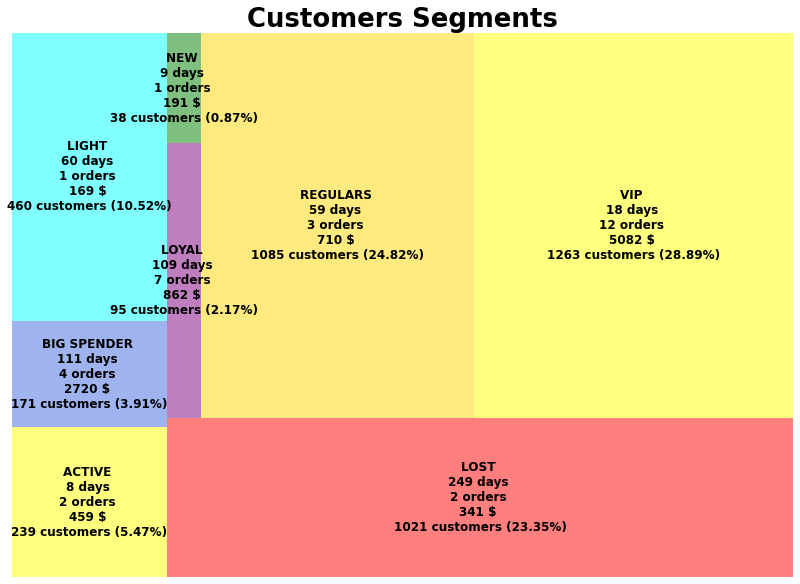

In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'POTENTIAL':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments.png')
plt.show()

In [ ]:
fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)
fig.show()

In [ ]:
fig = px.scatter_3d(df_RFM, x='Recency', y='Frequency', z='Monetary',
                    color = 'RFM_Level', opacity=0.5,
                    color_discrete_map = colors_dict)
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='markers'))
fig.show()

## Nhận xét:
- Số lượng khách hàng có nguy cơ ra đi (LOST) chiếm tỷ lệ rất lớn (23.35%) -> cần có giải pháp giữ chân khách hàng vì số lượng quá lớn sẽ ảnh hưởng nghiêm trọng đến doanh thu của doanh nghiệp
- Số lượng khách hàng VIP (mua hàng gần đây, số lượng đơn hàng nhiều, số tiền mua hàng lớn) chiếm 28.89%
- Số lượng khách hàng BIG SPENDER (chi nhiều tiền mua hàng) chiếm 3.91%
- Số lượng khách hàng LIGHT (chi ít tiền mua hàng) chiếm 10.52%
- Số lượng khách hàng ACTIVE (còn mua hàng gần đây) chiếm 5.47%
- Số lượng khách hàng LOYAL (số lượng đơn hàng nhiều) chiếm 2.17%
- Số lượng khách hàng NEW (mua hàng gần đây, số lượng đơn hàng ít, số tiền ít) chiếm 0.87%
- Số lượng khách hàng REGULARS (thông thường) chiếm 24.82%

## Kmeans clusters with the Elbow Method

In [ ]:
df_now = df_RFM[['Recency', 'Frequency', 'Monetary']]
df_now

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,1,77,279489.02
18102.0,0,62,256438.49
17450.0,8,55,187322.17
14911.0,1,248,132458.73
12415.0,24,26,123725.45
...,...,...,...
12503.0,337,1,-1126.00
17603.0,50,5,-1165.30
14213.0,371,1,-1192.20


In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_now)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

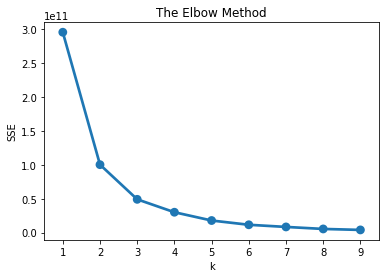

In [ ]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

- K có thể nhận giá trị trong khoảng 3-6. Có 2 điểm gãy ở k=3 và k=5 tuy nhiên nếu chia KH làm 3 nhóm thì số lượng nhóm ít và dễ dẫn tới những chiến lược không phù hợp cho việc chăm sóc KH.
- Đầu tiên em sẽ phân cụm với k=5

In [ ]:
# Build model with k=5
model = KMeans(n_clusters=5, random_state=42)
model.fit(df_now)
model.labels_.shape

(4372,)

In [ ]:
df_now["Cluster"] = model.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         20.28     19.53    8072.61   267
1          8.80     88.20  128969.26     5
2          0.50     69.50  267963.76     2
3          6.33     58.26   40961.31    27
4         96.97      3.64     942.37  4071

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg2 = df_now.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,20.0,20.0,8073.0,267,6.11
1,Cluster 1,9.0,88.0,128969.0,5,0.11
2,Cluster 2,0.0,70.0,267964.0,2,0.05
3,Cluster 3,6.0,58.0,40961.0,27,0.62
4,Cluster 4,97.0,4.0,942.0,4071,93.12


- Với k = 5, dữ liệu tập trung tới 93.12% vào 1 nhóm, trong khi 4 nhóm còn lại chỉ chiếm tỷ lệ rất nhỏ.
- Nhận thấy kết quả không phù hợp nên em sẽ phân cụm với k khác để tìm k phù hợp hơn.

In [ ]:
# Build model with k=3
model = KMeans(n_clusters=3, random_state=42)
model.fit(df_now)
model.labels_.shape

(4372,)

In [ ]:
df_now["Cluster"] = model.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         92.09      4.72    1428.99  4346
1          3.00     64.67  241083.23     3
2          7.35     64.39   58473.58    23

- Dễ nhận thấy dữ liệu gom vào 1 nhóm lớn và 2 nhóm còn lại rất ít dữ liệu nên cũng không phù hợp

In [ ]:
# Build model with k=4
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_now)
model.labels_.shape

(4372,)

In [ ]:
df_now["Cluster"] = model.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         93.78      4.20    1155.97  4252
1          3.00     64.67  241083.23     3
2          7.40     67.87   71538.93    15
3         14.94     30.49   15362.56   102

In [ ]:
# Build model with k=6
model = KMeans(n_clusters=6, random_state=42)
model.fit(df_now)
model.labels_.shape

(4372,)

In [ ]:
df_now["Cluster"] = model.labels_
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0         24.88     15.42    5892.83   412
1          0.50     69.50  267963.76     2
2         99.74      3.34     820.32  3906
3          6.42     56.50   58640.43    12
4         12.53     44.22   23616.02    36
5         10.50     98.75  139180.24     4

## Nhận xét:
- Sử dụng RFM kết hợp với KMeans trong bài toán này cho kết quả không tốt so với chỉ sử dụng RFM thuần túy. Với k từ 3 đến 6 thì khoảng 90-99.4% dữ liệu tập trung ở 1 phân cụm khách hàng.
- Cần phải scale dữ liệu trước khi áp dụng Kmeans

In [ ]:
df_cluster= df_RFM[['Recency', 'Frequency', 'Monetary']]

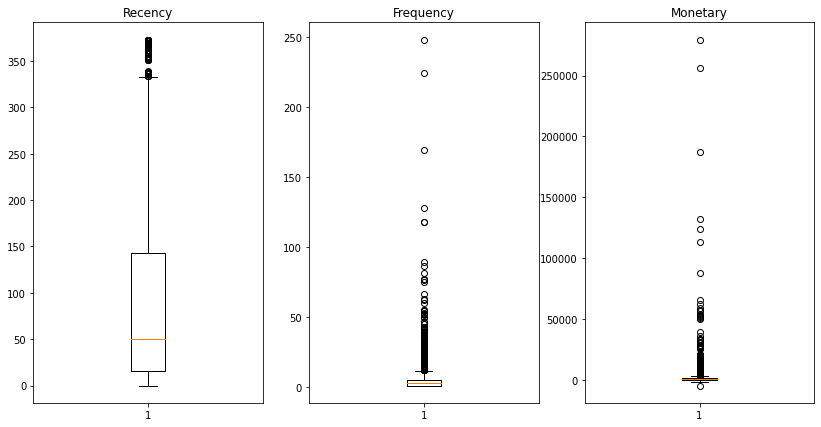

In [ ]:
# check outliers
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
plt.boxplot(df_cluster['Recency'])
plt.title('Recency')
plt.subplot(1, 3, 2)
plt.boxplot(df_cluster['Frequency'])
plt.title('Frequency')
plt.subplot(1, 3, 3)
plt.boxplot(df_cluster['Monetary'])
plt.title('Monetary')
plt.show()

Nhận xét: Các biến đều có số lượng outliers lớn, ở nhóm monetary là đặc biệt lớn. Tuy nhiên, chính những KH có số tiền mua lớn là những KH quan trọng nhất, mang lại doanh thu cao cho doanh nghiệp nên được giữ lại => chỉ loại outliers của recency (KH đã mua từ quá lâu) và frequency (KH mua quá nhiều lần).

In [ ]:
# Removing (statistical) outliers for Recency
Q1 = df_cluster.Recency.quantile(0.25)
Q3 = df_cluster.Recency.quantile(0.75)
IQR = Q3 - Q1
df_cluster = df_cluster[(df_cluster.Recency >= Q1 - 1.5*IQR) & (df_cluster.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = df_cluster.Frequency.quantile(0.25)
Q3 = df_cluster.Frequency.quantile(0.75)
IQR = Q3 - Q1
df_cluster = df_cluster[(df_cluster.Frequency >= Q1 - 1.5*IQR) & (df_cluster.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform
df_cluster_scaled = scaler.fit_transform(df_cluster)
df_cluster_scaled.shape

(3921, 3)

In [ ]:
df_cluster_scaled = pd.DataFrame(df_cluster_scaled)
df_cluster_scaled.columns = ['Recency', 'Frequency', 'Monetary']
df_cluster_scaled.head()

,Recency,Frequency,Monetary
0,1.633793,0.177912,14.389649
1,-0.942958,2.630524,14.029790
2,-0.509797,3.331271,11.614459
3,-0.865211,3.331271,9.230721
4,-0.976278,1.229032,8.653150


## Áp dụng KMeans

In [ ]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster_scaled)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

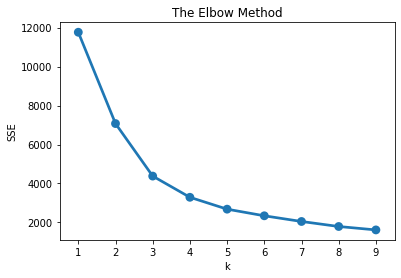

In [ ]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

- Có các điểm gãy ở k=3 và k=4 tuy nhiên em sẽ chọn k=4 (phân KH làm 3 nhóm thì ít quá, dễ dẫn đến CSKH không phù hợp)

In [ ]:
# Build model with k=4
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_cluster_scaled)
model.labels_.shape

(3921,)

- Sau khi fit model để tìm ra labels_ thì em nhận thấy khi tạo cột Cluster và gom nhóm theo Cluster với df_cluster (dữ liệu chưa scale) hay df_cluster_scaled (dữ liệu đã scaled) cho kết quả giống nhau. 
- Giải thích: 2df này khác nhau nhưng bản chất đều là dữ liệu của chính khách hàng đó (dù chưa scale hay đã scale thì đối tượng của mỗi dòng dữ liệu chính là 1 khách hàng duy nhất với CustomerID tương ứng)
- Vì vậy em sử dụng df_cluster để nhìn rõ tính chất từng nhóm KH hơn. Nhận xét này được áp dụng với các thuật toán sẽ thử nghiệm bên dưới nữa.

In [ ]:
df_cluster["Cluster"] = model.labels_
df_cluster.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         48.26      2.38   638.80  2053
1         32.52      7.57  2211.21   858
2        229.70      1.76   408.07   936
3         36.16      9.07  8013.28    74

In [ ]:
df_cluster.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
15749.0,235,4,21535.90,3
12753.0,3,11,21024.01,3
12678.0,42,13,17588.26,3
14866.0,10,13,14197.45,3
12433.0,0,7,13375.87,3


In [ ]:
df_cluster.describe()

,Recency,Frequency,Monetary,Cluster
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,87.900026,3.492221,1066.973639,0.752869
std,90.047364,2.854464,1422.657172,0.881431
min,0.000000,1.000000,-4287.630000,0.000000
25%,19.000000,1.000000,289.780000,0.000000
50%,52.000000,2.000000,610.010000,0.000000
75%,137.000000,5.000000,1331.390000,2.000000
max,333.000000,13.000000,21535.900000,3.000000


In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg2 = df_cluster.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,48.0,2.0,639.0,2053,52.36
1,Cluster 1,33.0,8.0,2211.0,858,21.88
2,Cluster 2,230.0,2.0,408.0,936,23.87
3,Cluster 3,36.0,9.0,8013.0,74,1.89


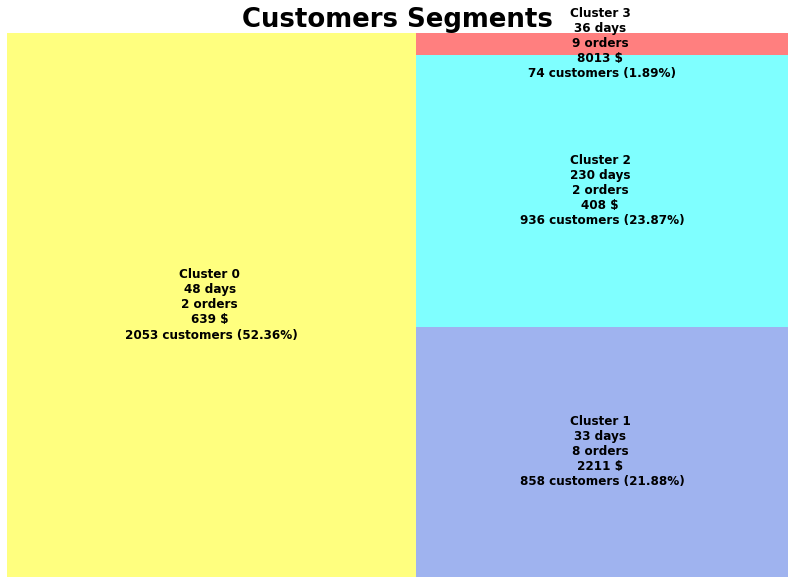

In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('KMeans Segments.png')
plt.show()

In [ ]:
fig = px.scatter_3d(rfm_agg2, x='RecencyMean', y='FrequencyMean', z='MonetaryMean',
                    color = 'Cluster', opacity=0.3)
fig.update_traces(marker=dict(size=20),
                  
                  selector=dict(mode='markers'))
fig.show()

## Nhận xét: Chia KH thành 4 nhóm:
- Cluster 0: thời gian mua hàng trung bình, số đơn hàng trung ít, số tiền trung bình chiếm 52.36%
- Cluster 1: mua hàng gần đây, số đơn hàng lớn, số tiền lớn (KH VIP) chiếm 21.88%
- Cluster 2: thời gian mua hàng xa, số đơn hàng ít, số tiền ít (KH có nguy cơ ra đi) chiếm 23.87%
- Cluster 3: thời gian mua hàng gần đây, số đơn hàng lớn, số tiền rất lớn (KH VIP) chiếm 1.89%

## Áp dụng Hierarchy

In [ ]:
df_hierarchy = df_cluster_scaled[['Recency', 'Frequency', 'Monetary']]

In [ ]:
df_hierarchy.head()

,Recency,Frequency,Monetary
0,1.633793,0.177912,14.389649
1,-0.942958,2.630524,14.029790
2,-0.509797,3.331271,11.614459
3,-0.865211,3.331271,9.230721
4,-0.976278,1.229032,8.653150


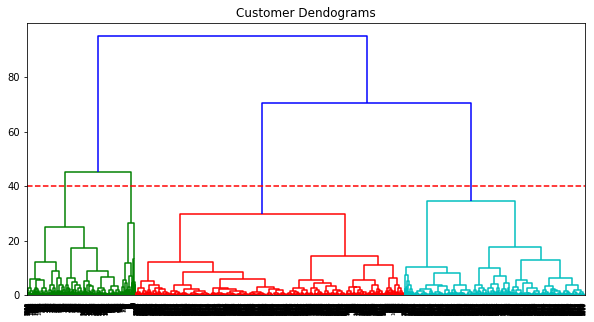

In [ ]:
from scipy.cluster import hierarchy
plt.figure(figsize=(10, 5))
plt.title("Customer Dendograms")
dend = hierarchy.dendrogram(hierarchy.linkage(df_hierarchy, method='ward')) 
plt.axhline(y=40, color='r', linestyle='--')

In [ ]:
# cluster = 4
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4,
                                affinity='euclidean', linkage='ward')
cluster.fit(df_hierarchy)

AgglomerativeClustering(n_clusters=4)

In [ ]:
cluster.labels_

array([1, 1, 1, ..., 2, 0, 0])

In [ ]:
df_cluster['Cluster'] = cluster.labels_
df_cluster.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
15749.0,235,4,21535.90,1
12753.0,3,11,21024.01,1
12678.0,42,13,17588.26,1
14866.0,10,13,14197.45,1
12433.0,0,7,13375.87,1


In [ ]:
df_cluster.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        197.33      1.95   460.45  1268
1         31.61      8.48  7227.09    98
2         36.21      2.64   714.92  1889
3         34.44      8.11  2313.83   666

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg2 = df_cluster.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,197.0,2.0,460.0,1268,32.34
1,Cluster 1,32.0,8.0,7227.0,98,2.50
2,Cluster 2,36.0,3.0,715.0,1889,48.18
3,Cluster 3,34.0,8.0,2314.0,666,16.99


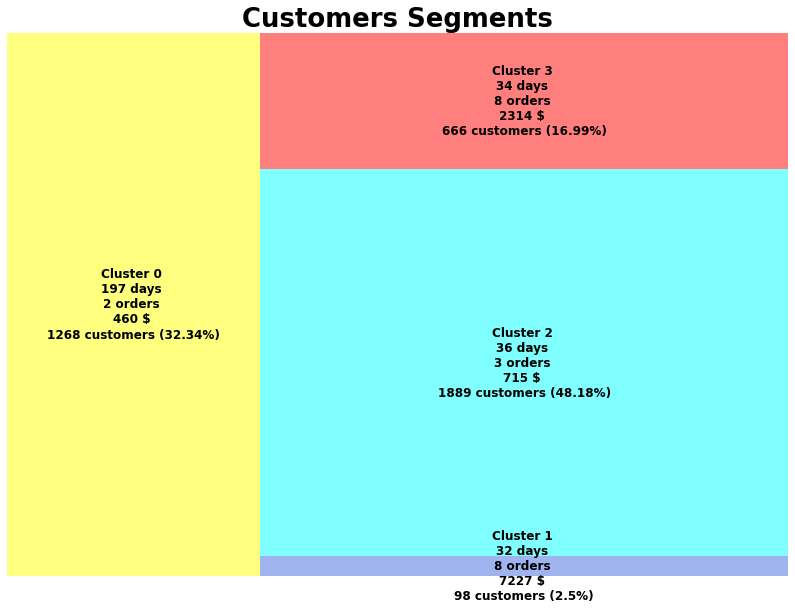

In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Hierarchy Segments.png')
plt.show()

In [ ]:
fig = px.scatter_3d(rfm_agg2, x='RecencyMean', y='FrequencyMean', z='MonetaryMean',
                    color = 'Cluster', opacity=0.3)
fig.update_traces(marker=dict(size=20),
                  
                  selector=dict(mode='markers'))
fig.show()

## Nhận xét: Khách hàng chia làm 4 nhóm:
- Cluster 0: Khách hàng có thời gian  mua hàng xa, số đơn hàng ít, số tiền ít (KH có nguy cơ ra đi) chiếm 32.34%
- Cluster 1: Thời gian mua hàng gần đây, số đơn hàng lớn, số tiền rất lớn (KH VIP) chiếm 2.5%
- Cluster 2: Thời gian mua hàng trung bình, số đơn hàng trung bình, số tiền trung bình (KH thông thường) chiếm 48.18%
- Cluster 3: Thời gian mua hàng gần đây, số đơn hàng lớn, số tiền lớn chiếm 16.99%

## Áp dụng GMM

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture

In [ ]:
df_GMM = df_cluster_scaled[['Recency', 'Frequency', 'Monetary']]

In [ ]:
list_sil = []
K = range(4,9)
for k in K:
 gmm = GaussianMixture(n_components=k)
 gmm.fit(df_GMM)
 labels = gmm.predict(df_GMM)
 sil = metrics.silhouette_score(df_GMM, labels, metric='euclidean')
 list_sil.append(sil)

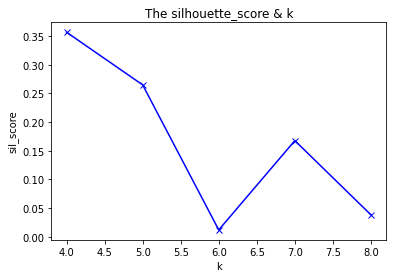

In [ ]:
# Plot
plt.plot(K, list_sil, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('The silhouette_score & k')
plt.show()

- Số cụm k=4 được đề xuất vì có sil lớn nhất

In [ ]:
gmm = GaussianMixture(n_components=4)
gmm.fit(df_GMM)

GaussianMixture(n_components=4)

In [ ]:
print(gmm.weights_)

[0.35411562 0.26185355 0.2667394  0.11729142]


In [ ]:
print(gmm.means_)

[[-0.52740631 -0.46406389 -0.39834159]
 [ 1.27352765 -0.68869378 -0.5253953 ]
 [-0.70189638  0.99243367  0.51138525]
 [ 0.34536624  0.68161869  1.21261225]]


In [ ]:
print(gmm.covariances_)

[[[ 0.09908884 -0.01374744  0.00685212]
  [-0.01374744  0.16371955  0.05138127]
  [ 0.00685212  0.05138127  0.04722175]]

 [[ 0.70722985 -0.03785533 -0.01252671]
  [-0.03785533  0.06307391  0.01461379]
  [-0.01252671  0.01461379  0.02188838]]

 [[ 0.05468016 -0.05472163 -0.01874903]
  [-0.05472163  1.02233067  0.29238781]
  [-0.01874903  0.29238781  0.40948256]]

 [[ 0.8230898  -0.43772662 -0.92364437]
  [-0.43772662  1.15220279  1.03142814]
  [-0.92364437  1.03142814  4.24264311]]]


In [ ]:
cluster.labels_ = gmm.predict(df_GMM)
df_cluster['Cluster'] = cluster.labels_
df_cluster.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
15749.0,235,4,21535.90,3
12753.0,3,11,21024.01,3
12678.0,42,13,17588.26,3
14866.0,10,13,14197.45,3
12433.0,0,7,13375.87,3


In [ ]:
df_cluster.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         40.97      2.11   488.94  1497
1        212.44      1.50   315.30   968
2         23.88      6.54  1864.43  1032
3        125.10      5.49  2882.90   424

In [ ]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg2 = df_cluster.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,41.0,2.0,489.0,1497,38.18
1,Cluster 1,212.0,2.0,315.0,968,24.69
2,Cluster 2,24.0,7.0,1864.0,1032,26.32
3,Cluster 3,125.0,5.0,2883.0,424,10.81


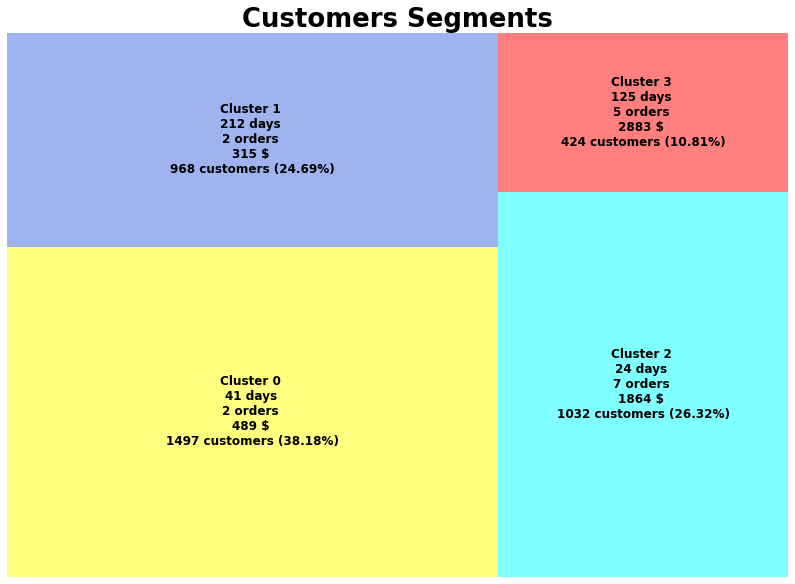

In [ ]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('GMM Segments.png')
plt.show()

In [ ]:
fig = px.scatter_3d(rfm_agg2, x='RecencyMean', y='FrequencyMean', z='MonetaryMean',
                    color = 'Cluster', opacity=0.3)
fig.update_traces(marker=dict(size=20),
                  
                  selector=dict(mode='markers'))
fig.show()

## Nhận xét: Khách hàng chia làm 4 nhóm:
- Cluster 0: Thời gian mua hàng trung bình, số đơn hàng ít, số tiền ít chiếm 38.18%
- Cluster 1: Thời gian mua hàng xa, số đơn hàng ít, số tiền ít (KH có nguy cơ ra đi) chiếm 24.69%
- Cluster 2: Thời gian mua hàng gần, số đơn hàng lớn, số tiền lớn chiếm 26.32%
- Cluster 3: Khách hàng có thời gian mua hàng xa, số đơn hàng khá, số tiền rất lớn chiếm 10.81%

## Áp dụng DBSCAN

In [ ]:
from numpy import where
from numpy import unique

from sklearn.cluster import DBSCAN

In [ ]:
df_dbscan = df_cluster_scaled[['Recency', 'Frequency', 'Monetary']]

In [ ]:
df_dbscan.head()

,Recency,Frequency,Monetary
0,1.633793,0.177912,14.389649
1,-0.942958,2.630524,14.029790
2,-0.509797,3.331271,11.614459
3,-0.865211,3.331271,9.230721
4,-0.976278,1.229032,8.653150


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(df_dbscan)
distances, indices = neighbors_fit.kneighbors(df_dbscan)
distances = np.sort(distances, axis=0)

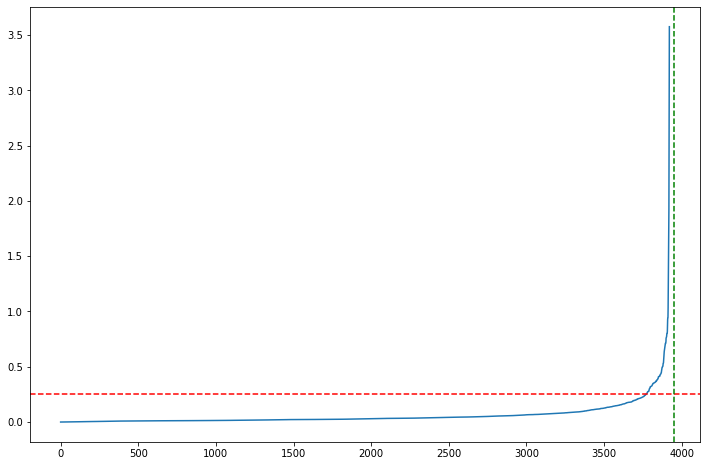

In [ ]:
# Theo phương pháp khuỷu tay để tìm esp (Epsilon (ε))
plt.figure(figsize=(12,8))
distances_draw = distances[:,1]
plt.plot(distances_draw)
plt.axhline(y=0.25, color='r', linestyle='--')
plt.axvline(x=3950, color='g', linestyle='--')

In [ ]:
dbscan_model = DBSCAN(eps = 0.25, min_samples = 6)

In [ ]:
dbscan_model.fit(df_dbscan)

DBSCAN(eps=0.25, min_samples=6)

In [ ]:
unique(dbscan_model.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24])

Dữ liệu được chia thành 26 nhóm là quá nhiều nhóm nên DBSCAN không phù hợp cho bài toán này.

# Kết luận: 
- Rất khó để nói cách phân cụm KH nào tốt hơn, điều này tùy thuộc vào tiêu chí cụ thể doanh nghiệp đưa ra
- Cá nhân em lựa chọn cách phân cụm KH có sự kết hợp giữa RFM và GMM do tỷ lệ các nhóm hợp lý và tính chất KH trong mỗi nhóm rõ ràng hơn.
- Tùy theo chiến lược của doanh nghiệp, cần phối hợp với các phòng ban khác để đề ra chiến lược marketing và chăm sóc KH phù hợp cho mỗi nhóm KH để bán được nhiều sản phẩm hơn từ đó tăng doanh thu và lợi nhuận cho doanh nghiệp.